# Exercises: Anomaly Detection - CONTINUOUS PROBABALISTIC METHODS
<a href = "https://ds.codeup.com/anomaly-detection/continuous-probabilistic-methods/#exercises">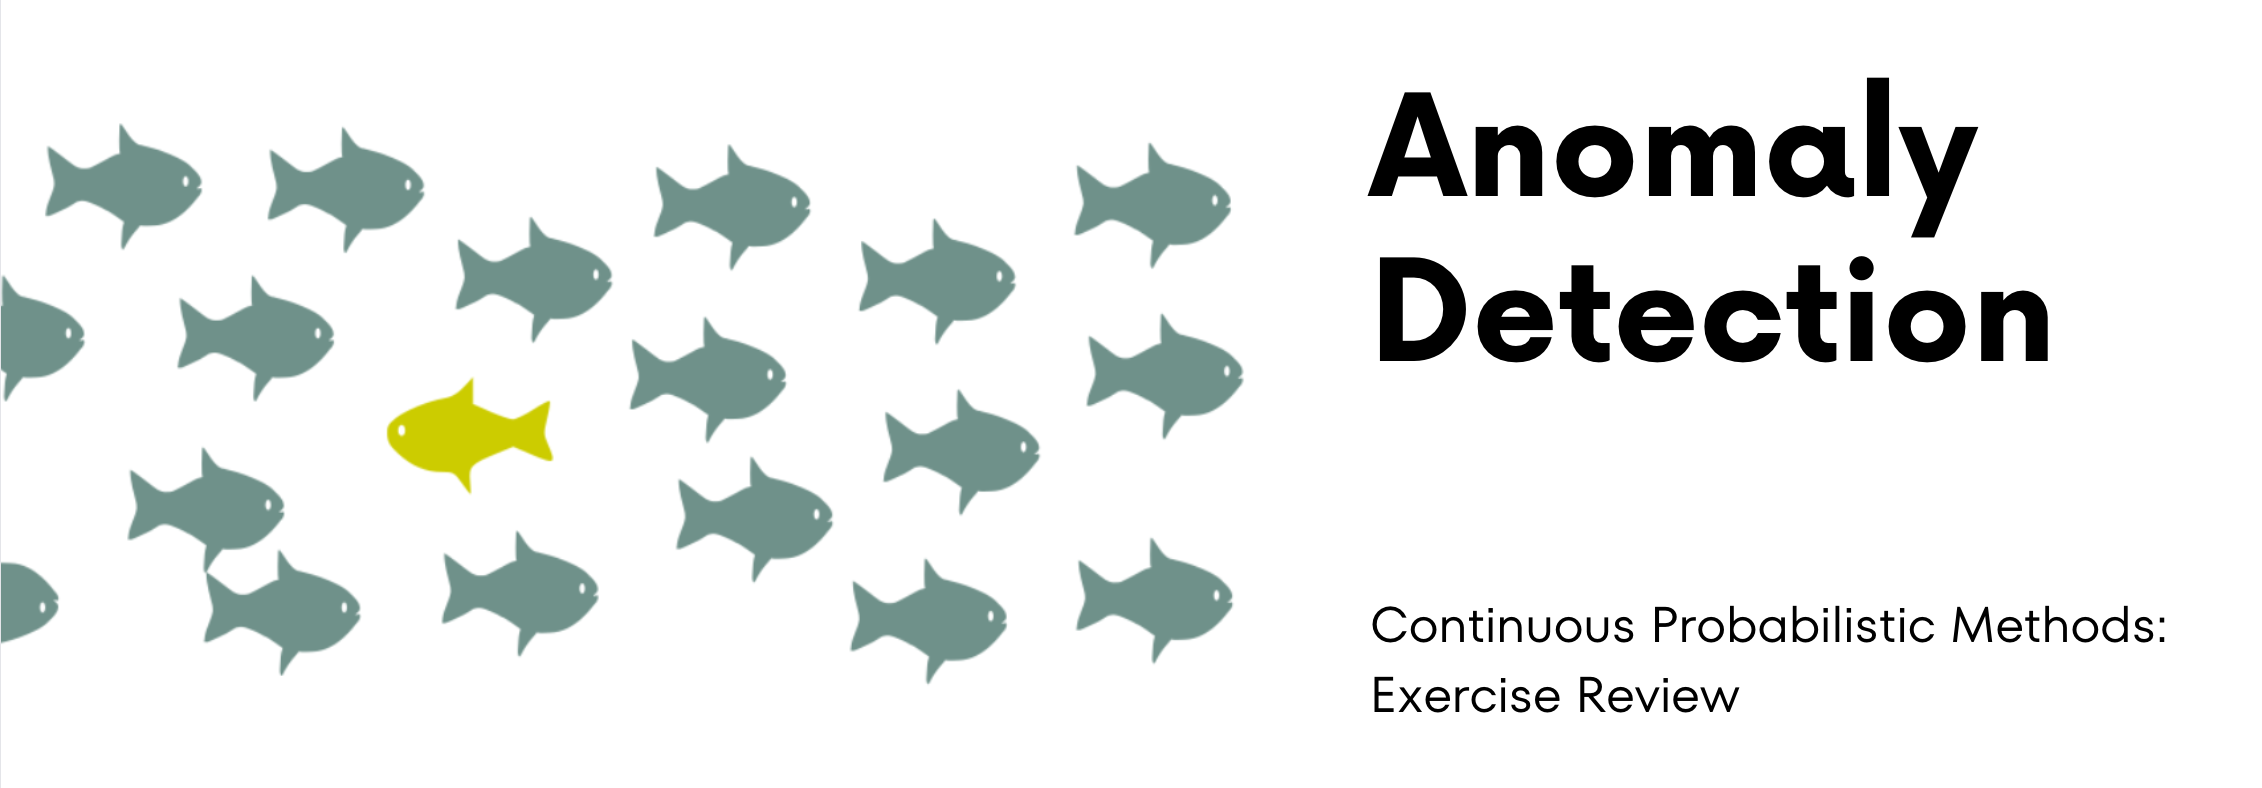</a>

<hr style="border:2px solid gray">

Using the repo setup directions, setup a new local and remote repository named `anomaly-detection-exercises`. The local version of your repo should live inside of `~/codeup-data-science`. This repo should be named `anomaly-detection-exercises`

Save this work in your `anomaly-detection-exercises` repo. Then add, commit, and push your changes.

`continuous_probabilistic_methods.py` or `continuous_probabilistic_methods.ipynb` 

1. Define a function named `get_lower_and_upper_bounds` that has two arguments. The first argument is a pandas Series. The second argument is the multiplier, which should have a default argument of 1.5.

In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [33]:
def get_lower_and_upper_bounds(s, m=1.5):
    '''
    Given a series and a cutoff value, m, returns the upper/lower outlier bounds for the
    series.
    '''
    
    q1, q3 = s.quantile([.25, 0.75])
    
    iqr = q3 - q1
    
    upper_bound = q3 + (m * iqr)
    lower_bound = q1 - (m * iqr)
        
    return lower_bound, upper_bound

# 1. Using <a href="https://gist.githubusercontent.com/ryanorsinger/19bc7eccd6279661bd13307026628ace/raw/e4b5d6787015a4782f96cad6d1d62a8bdbac54c7/lemonade.csv">`lemonade.csv`</a> dataset and focusing on continuous variables:

In [4]:
df = pd.read_csv('https://gist.githubusercontent.com/ryanorsinger/19bc7eccd6279661bd13307026628ace/raw/lemonade.csv')

In [5]:
df.head()

,Date,Day,Temperature,Rainfall,Flyers,Price,Sales
0,1/1/17,Sunday,27.0,2.00,15,0.5,10
1,1/2/17,Monday,28.9,1.33,15,0.5,13
2,1/3/17,Tuesday,34.5,1.33,27,0.5,15
3,1/4/17,Wednesday,44.1,1.05,28,0.5,17
4,1/5/17,Thursday,42.4,1.00,33,0.5,18


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         365 non-null    object 
 1   Day          365 non-null    object 
 2   Temperature  365 non-null    float64
 3   Rainfall     365 non-null    float64
 4   Flyers       365 non-null    int64  
 5   Price        365 non-null    float64
 6   Sales        365 non-null    int64  
dtypes: float64(3), int64(2), object(2)
memory usage: 20.1+ KB


In [7]:
# It looks like every row is a date, so 
# let's treat it like a datetime index
df['Date'] = pd.to_datetime(df.Date)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         365 non-null    datetime64[ns]
 1   Day          365 non-null    object        
 2   Temperature  365 non-null    float64       
 3   Rainfall     365 non-null    float64       
 4   Flyers       365 non-null    int64         
 5   Price        365 non-null    float64       
 6   Sales        365 non-null    int64         
dtypes: datetime64[ns](1), float64(3), int64(2), object(1)
memory usage: 20.1+ KB


In [9]:
# reset the datetime version of Date as our index:
df = df.set_index('Date')

In [10]:
df.head()

,Day,Temperature,Rainfall,Flyers,Price,Sales
Date,,,,,,
2017-01-01,Sunday,27.0,2.00,15,0.5,10
2017-01-02,Monday,28.9,1.33,15,0.5,13
2017-01-03,Tuesday,34.5,1.33,27,0.5,15
2017-01-04,Wednesday,44.1,1.05,28,0.5,17
2017-01-05,Thursday,42.4,1.00,33,0.5,18


In [11]:
# let's add a month feature now that we have a datetime index
df['Month'] = df.index.month_name()

In [12]:
df.head(2)

,Day,Temperature,Rainfall,Flyers,Price,Sales,Month
Date,,,,,,,
2017-01-01,Sunday,27.0,2.00,15,0.5,10,January
2017-01-02,Monday,28.9,1.33,15,0.5,13,January


In [14]:
df.Month.value_counts()

January      31
March        31
May          31
July         31
August       31
October      31
December     31
April        30
June         30
September    30
November     30
February     28
Name: Month, dtype: int64

In [15]:
df.describe()

,Temperature,Rainfall,Flyers,Price,Sales
count,365.000000,365.000000,365.000000,365.0,365.000000
mean,61.224658,0.825973,40.104110,0.5,27.865753
std,18.085892,0.273890,13.786445,0.0,30.948132
min,15.100000,0.400000,-38.000000,0.5,7.000000
25%,49.700000,0.650000,31.000000,0.5,20.000000
50%,61.100000,0.740000,39.000000,0.5,25.000000
75%,71.700000,0.910000,49.000000,0.5,30.000000
max,212.000000,2.500000,80.000000,0.5,534.000000


In [16]:
def get_object_cols(df):
    '''
    This function takes in a dataframe and identifies the columns that are object types
    and returns a list of those column names. 
    '''
    # get a list of the column names that are objects (from the mask)
    object_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    
    return object_cols



def get_numeric_cols(df):
    '''
    This function takes in a dataframe and identifies the columns that are object types
    and returns a list of those column names. 
    '''
    # get a list of the column names that are objects (from the mask)
    num_cols = df.select_dtypes(exclude=['object', 'category']).columns.tolist()
    
    return num_cols


In [17]:
numeric_cols = get_numeric_cols(df)
object_cols = get_object_cols(df)

In [18]:
print(f"""Numerical: {numeric_cols}
Categorical: {object_cols}""")

Numerical: ['Temperature', 'Rainfall', 'Flyers', 'Price', 'Sales']
Categorical: ['Day', 'Month']


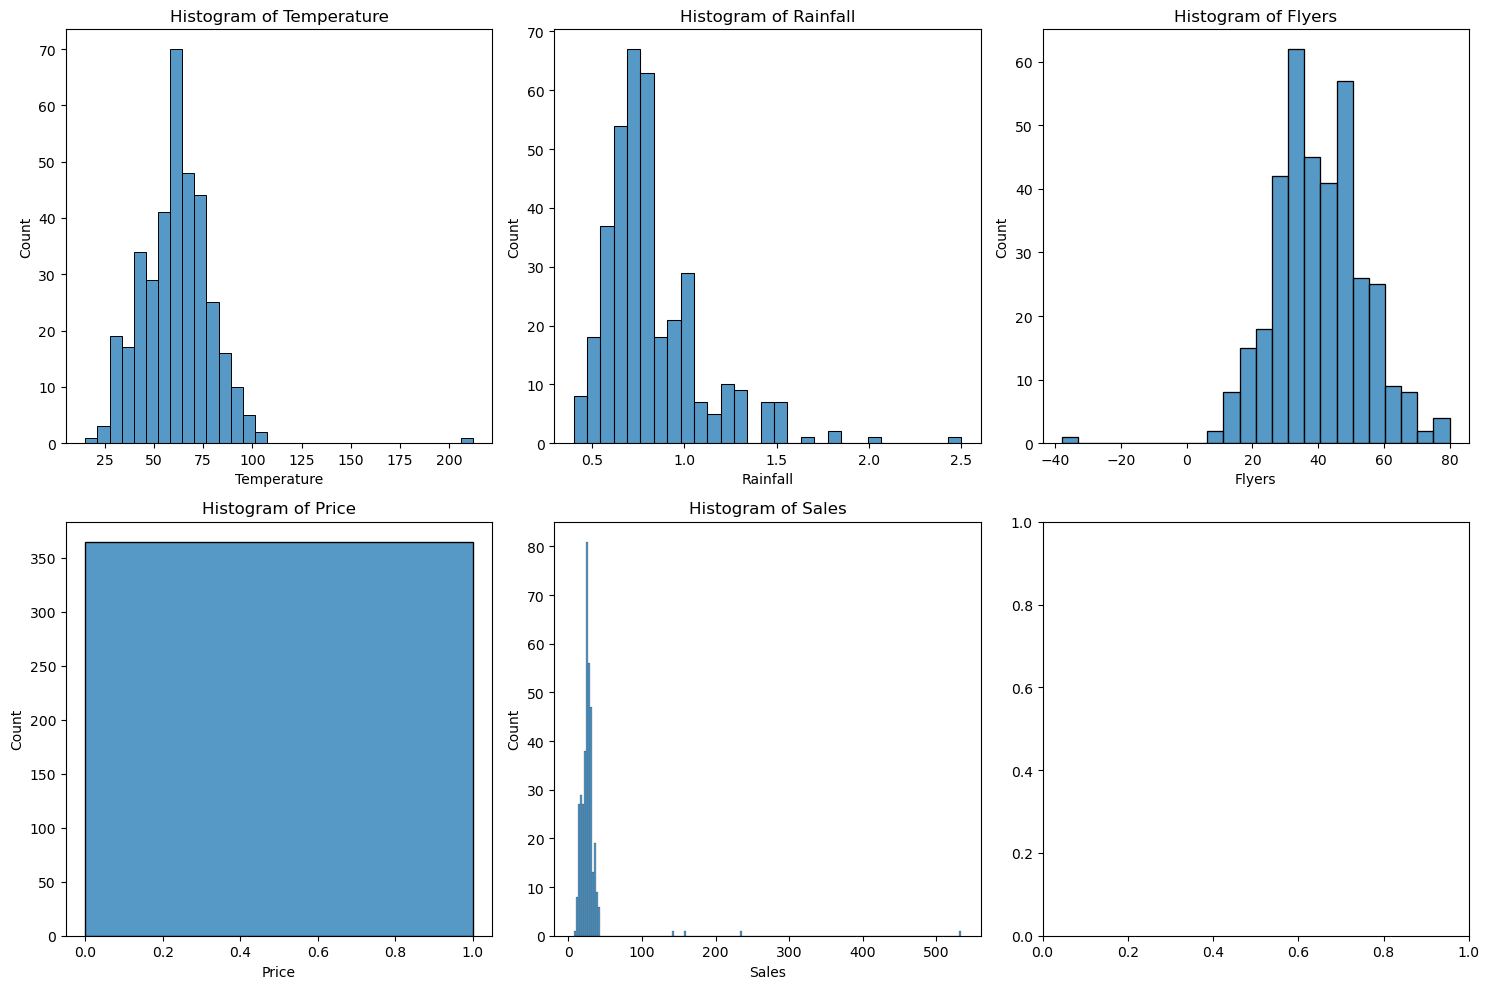

In [19]:
num_cols = len(numeric_cols)
num_rows, num_cols_subplot = divmod(num_cols, 3)
if num_cols_subplot > 0:
    num_rows += 1

fig, axes = plt.subplots(num_rows, 3, figsize=(15, num_rows * 5))

for i, col in enumerate(numeric_cols):
    row_idx, col_idx = divmod(i, 3)
    sns.histplot(df[col], ax=axes[row_idx, col_idx])
    axes[row_idx, col_idx].set_title(f'Histogram of {col}')

plt.tight_layout()
plt.show()


In [20]:
df.Price.value_counts()

0.5    365
Name: Price, dtype: int64

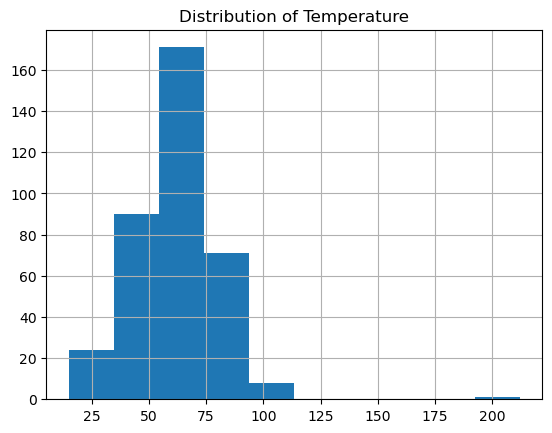

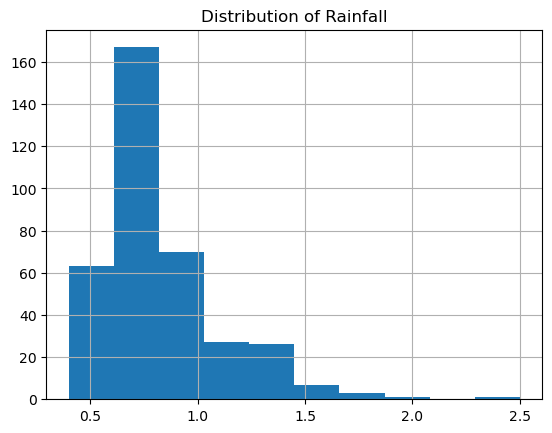

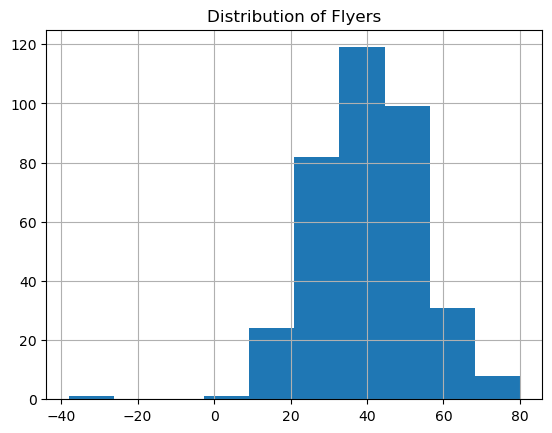

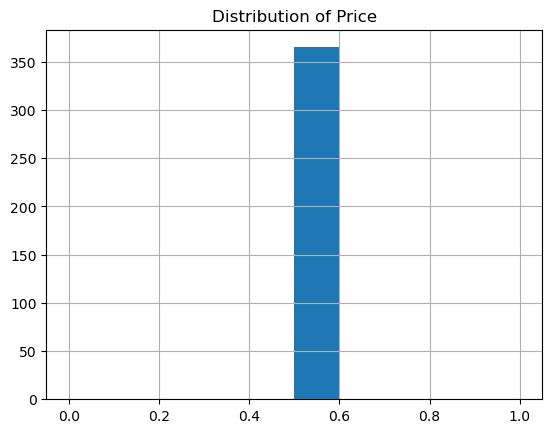

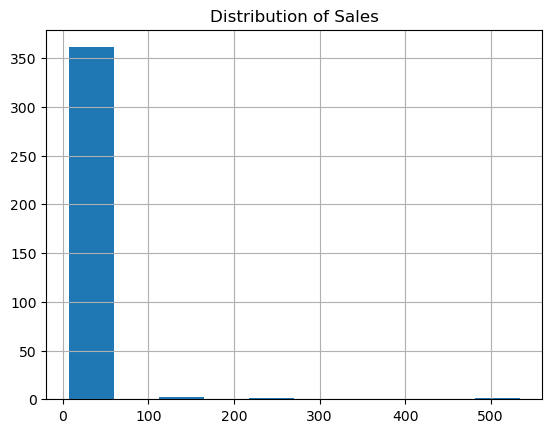

In [21]:
# initial visual check:
# histograms of numerical information
for col in numeric_cols:
    df[col].hist()
    plt.title(f'Distribution of {col}')
    plt.show()

<AxesSubplot:>

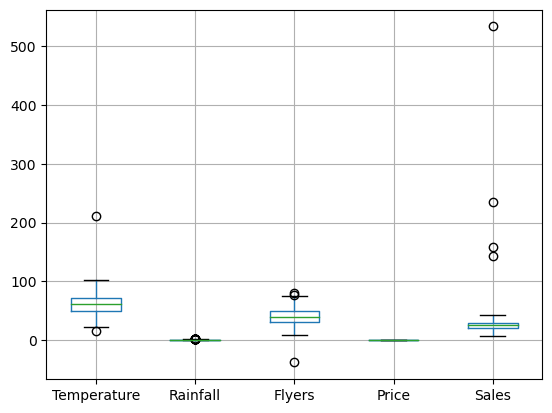

In [65]:
df.boxplot(column =numeric_cols)

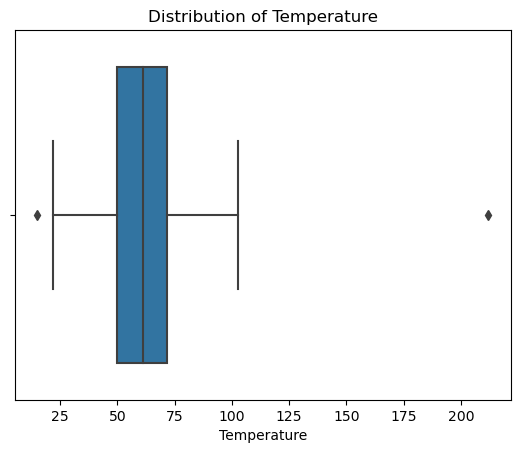

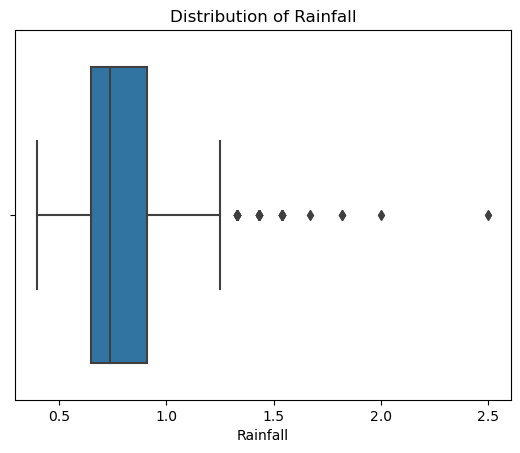

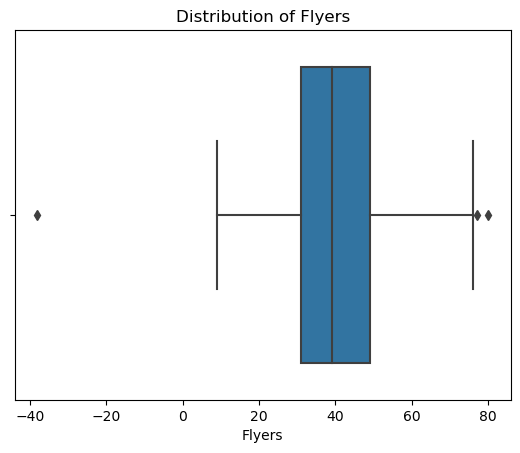

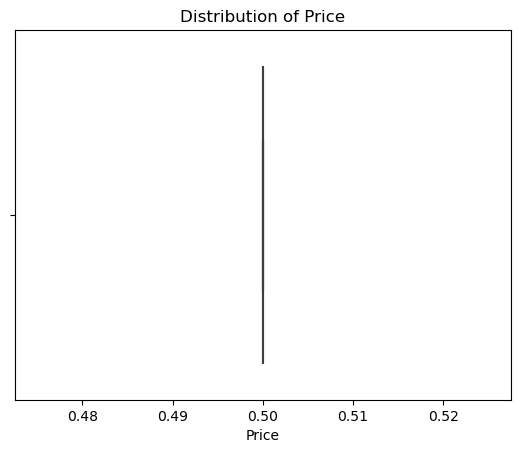

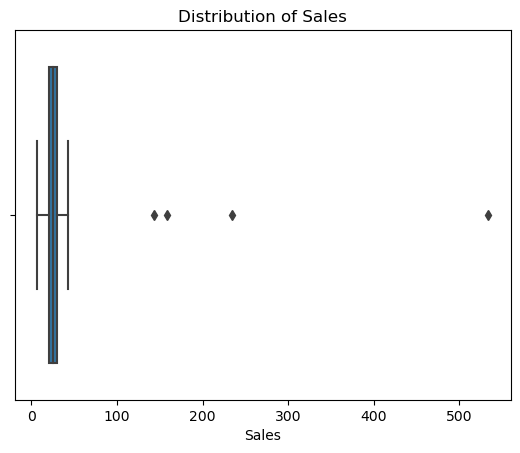

In [22]:
for col in numeric_cols:
    sns.boxplot(data=df, x=col)
    plt.title(f'Distribution of {col}')
    plt.show()

<div class="alert alert-success" role="alert">
    
## Takeaways:
    
- One day with extremely temperature
- One day with negative flyers
- Heavy rainfall day(s)?
- Extremely high sale days
    
</div>

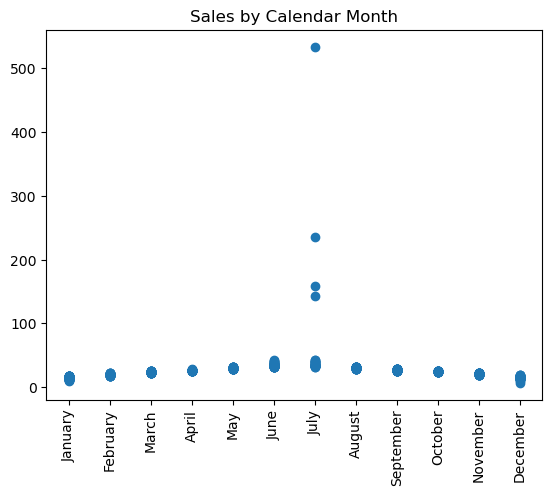

In [23]:
# sales, based on day/month
plt.scatter(df.Month, df.Sales)
plt.title('Sales by Calendar Month')
plt.xticks(rotation=90)
plt.show()

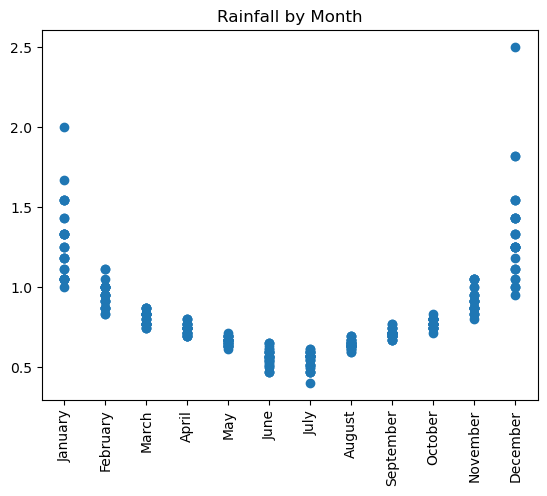

In [24]:
# what about rainfall?
plt.scatter(df.Month, df.Rainfall)
plt.title('Rainfall by Month')
plt.xticks(rotation=90)
plt.show()

## 1.a Use the IQR Range Rule and the upper and lower bounds to identify the lower outliers of each column of `lemonade.csv`, using the **multiplier of 1.5**. 
- Do these lower outliers make sense? 
- Which outliers should be kept?

In [34]:
get_lower_and_upper_bounds(df.Rainfall)

(0.26, 1.3)

In [35]:
# Create an empty dictionary to store outliers
outliers = {}

# Iterate over each column in the DataFrame
for col in df.columns:
    # Check if the column data type is numeric
    if np.issubdtype(df[col].dtype, np.number):
        # Get the lower and upper bounds for outlier detection
        lower_bound, upper_bound = get_lower_and_upper_bounds(df[col])
        
        # Print the lower and upper bounds for the current column
        print(f"""Lower bound for {col} : {lower_bound} 
Upper bound for {col}: {upper_bound}
_________________________________________""")
        
        # Create a sub-dictionary for the current column in the outliers dictionary
        outliers[col] = {}
        
        # Store the upper and lower bounds in the sub-dictionary
        outliers[col]['bounds'] = {'upper': upper_bound, 'lower': lower_bound}
        
        # Find the rows in the DataFrame where the column values are outside the bounds
        outliers[col]['df'] = df[(df[col] > upper_bound) | (df[col] < lower_bound)]
    else:
        # Skip non-numeric columns
        pass

Lower bound for Temperature : 16.700000000000003 
Upper bound for Temperature: 104.7
_________________________________________
Lower bound for Rainfall : 0.26 
Upper bound for Rainfall: 1.3
_________________________________________
Lower bound for Flyers : 4.0 
Upper bound for Flyers: 76.0
_________________________________________
Lower bound for Price : 0.5 
Upper bound for Price: 0.5
_________________________________________
Lower bound for Sales : 5.0 
Upper bound for Sales: 45.0
_________________________________________


In [47]:
outliers.keys()

dict_keys(['Temperature', 'Rainfall', 'Flyers', 'Price', 'Sales'])

In [37]:
outliers['Temperature'].keys()

dict_keys(['bounds', 'df'])

In [38]:
outliers['Temperature']['df']

,Day,Temperature,Rainfall,Flyers,Price,Sales,Month
Date,,,,,,,
2017-02-11,Saturday,212.0,0.91,35,0.5,21,February
2017-12-31,Sunday,15.1,2.50,9,0.5,7,December


In [55]:
for col in numeric_cols:
    print(f"""{col}:
{outliers[col]['df']}
_____________________________________""")

Temperature:
                 Day  Temperature  Rainfall  Flyers  Price  Sales     Month
Date                                                                       
2017-02-11  Saturday        212.0      0.91      35    0.5     21  February
2017-12-31    Sunday         15.1      2.50       9    0.5      7  December
_____________________________________
Rainfall:
                  Day  Temperature  Rainfall  Flyers  Price  Sales     Month
Date                                                                        
2017-01-01     Sunday         27.0      2.00      15    0.5     10   January
2017-01-02     Monday         28.9      1.33      15    0.5     13   January
2017-01-03    Tuesday         34.5      1.33      27    0.5     15   January
2017-01-06     Friday         25.3      1.54      23    0.5     11   January
2017-01-07   Saturday         32.9      1.54      19    0.5     13   January
2017-01-11  Wednesday         32.6      1.54      23    0.5     12   January
2017-01-12   Thursd

In [50]:
for i in range(len(numeric_cols)):
    print(outliers[numeric_cols[i]]['df'])

                 Day  Temperature  Rainfall  Flyers  Price  Sales     Month
Date                                                                       
2017-02-11  Saturday        212.0      0.91      35    0.5     21  February
2017-12-31    Sunday         15.1      2.50       9    0.5      7  December
                  Day  Temperature  Rainfall  Flyers  Price  Sales     Month
Date                                                                        
2017-01-01     Sunday         27.0      2.00      15    0.5     10   January
2017-01-02     Monday         28.9      1.33      15    0.5     13   January
2017-01-03    Tuesday         34.5      1.33      27    0.5     15   January
2017-01-06     Friday         25.3      1.54      23    0.5     11   January
2017-01-07   Saturday         32.9      1.54      19    0.5     13   January
2017-01-11  Wednesday         32.6      1.54      23    0.5     12   January
2017-01-12   Thursday         38.2      1.33      16    0.5     14   January
201

In [56]:
df.describe()

,Temperature,Rainfall,Flyers,Price,Sales
count,365.000000,365.000000,365.000000,365.0,365.000000
mean,61.224658,0.825973,40.104110,0.5,27.865753
std,18.085892,0.273890,13.786445,0.0,30.948132
min,15.100000,0.400000,-38.000000,0.5,7.000000
25%,49.700000,0.650000,31.000000,0.5,20.000000
50%,61.100000,0.740000,39.000000,0.5,25.000000
75%,71.700000,0.910000,49.000000,0.5,30.000000
max,212.000000,2.500000,80.000000,0.5,534.000000


## 1.b Using the **multiplier of 3**, IQR Range Rule, and the upper bounds, identify the outliers above the upper_bound in each colum of lemonade.csv. 
- Do these upper outliers make sense? 
- Which outliers should be kept?

In [57]:
# Create an empty dictionary to store outliers
outliers = {}

# Iterate over each column in the DataFrame
for col in df.columns:
    # Check if the column data type is numeric
    if np.issubdtype(df[col].dtype, np.number):
        # Get the lower and upper bounds for outlier detection
        lower_bound, upper_bound = get_lower_and_upper_bounds(df[col], m=3)
        
        # Print the lower and upper bounds for the current column
        print(f"""Lower bound for {col} : {lower_bound} 
Upper bound for {col}: {upper_bound}
_________________________________________""")
        
        # Create a sub-dictionary for the current column in the outliers dictionary
        outliers[col] = {}
        
        # Store the upper and lower bounds in the sub-dictionary
        outliers[col]['bounds'] = {'upper': upper_bound, 'lower': lower_bound}
        
        # Find the rows in the DataFrame where the column values are outside the bounds
        outliers[col]['df'] = df[(df[col] > upper_bound) | (df[col] < lower_bound)]
    else:
        # Skip non-numeric columns
        pass

Lower bound for Temperature : -16.299999999999997 
Upper bound for Temperature: 137.7
_________________________________________
Lower bound for Rainfall : -0.13 
Upper bound for Rainfall: 1.69
_________________________________________
Lower bound for Flyers : -23.0 
Upper bound for Flyers: 103.0
_________________________________________
Lower bound for Price : 0.5 
Upper bound for Price: 0.5
_________________________________________
Lower bound for Sales : -10.0 
Upper bound for Sales: 60.0
_________________________________________


In [58]:
for col in numeric_cols:
    print(f"""{col}:
{outliers[col]['df']}
_____________________________________""")

Temperature:
                 Day  Temperature  Rainfall  Flyers  Price  Sales     Month
Date                                                                       
2017-02-11  Saturday        212.0      0.91      35    0.5     21  February
_____________________________________
Rainfall:
                Day  Temperature  Rainfall  Flyers  Price  Sales     Month
Date                                                                      
2017-01-01   Sunday         27.0      2.00      15    0.5     10   January
2017-12-05  Tuesday         22.0      1.82      11    0.5     10  December
2017-12-10   Sunday         31.3      1.82      15    0.5     11  December
2017-12-31   Sunday         15.1      2.50       9    0.5      7  December
_____________________________________
Flyers:
                Day  Temperature  Rainfall  Flyers  Price  Sales     Month
Date                                                                      
2017-11-21  Tuesday         47.0      0.95     -38    0.5     20 

# 2. Identify if any columns in `lemonade.csv` are normally distributed. For normally distributed columns:

Temperature


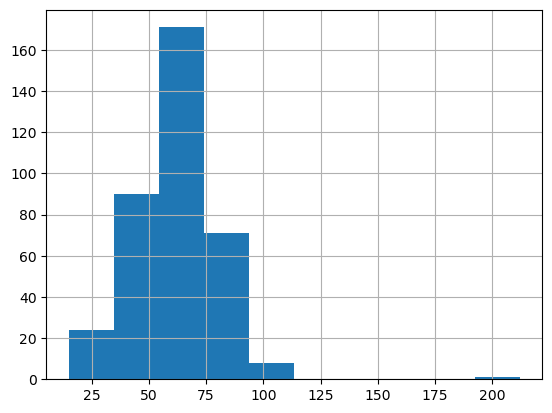

Rainfall


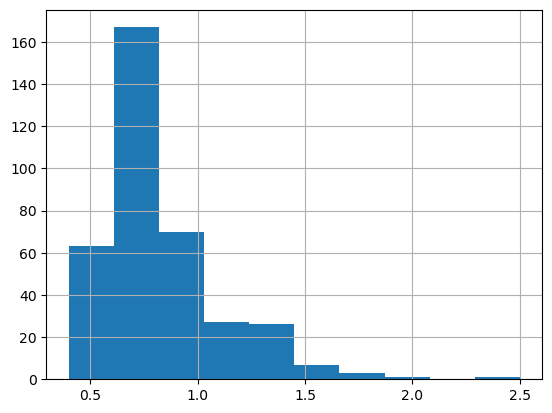

Flyers


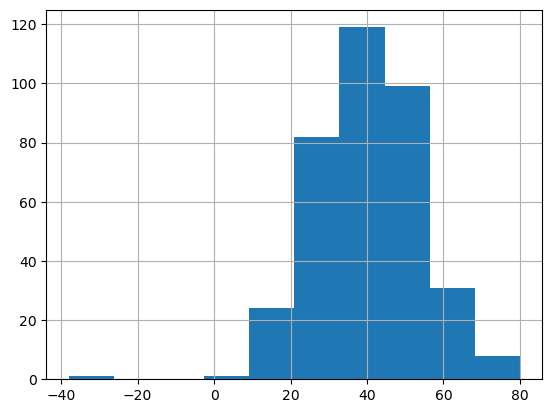

Price


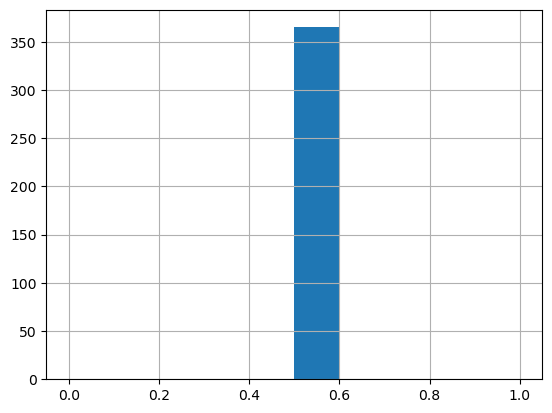

Sales


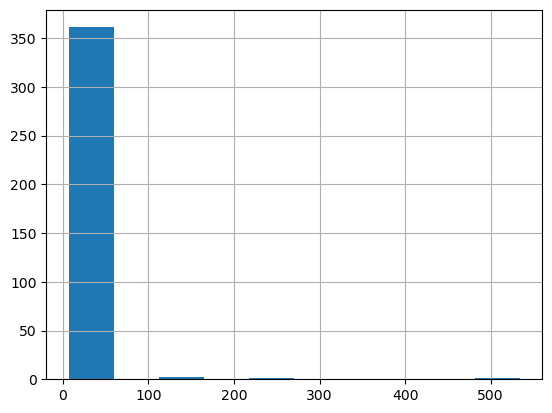

In [60]:
for col in df.columns:
    if np.issubdtype(df[col].dtype, np.number):
        df[col].hist()
        print(col)
        plt.show()

## 2.a Use a 2 sigma decision rule to isolate the outliers.
- Do these make sense?
- Should certain outliers be kept or removed?

In [63]:
# Iterate over each column in the list of numeric columns
for col in numeric_cols:
    # Calculate the z-scores for the current column
    z_scores = pd.Series((df[col] - df[col].mean()) / df[col].std())
    
    # Create a new column name for the z-scores
    colname = 'z_scores_' + str(col)
    
    # Add the z-scores as a new column in the DataFrame
     print(f"""{col}:
    
{df[z_scores.abs() >= 2]}
_____________________________________""")


Temperature:
    
                 Day  Temperature  Rainfall  Flyers  Price  Sales     Month  \
Date                                                                          
2017-02-11  Saturday        212.0      0.91      35    0.5     21  February   
2017-06-16    Friday         99.3      0.47      77    0.5     41      June   
2017-06-26    Monday        102.6      0.47      60    0.5     42      June   
2017-07-01  Saturday        102.9      0.47      59    0.5    143      July   
2017-07-10    Monday         98.0      0.49      66    0.5     40      July   
2017-07-18   Tuesday         99.3      0.47      76    0.5     41      July   
2017-07-22  Saturday         99.6      0.47      49    0.5     42      July   
2017-07-27  Thursday         97.9      0.47      74    0.5     43      July   
2017-12-05   Tuesday         22.0      1.82      11    0.5     10  December   
2017-12-31    Sunday         15.1      2.50       9    0.5      7  December   

            z_scores_Temperature 

# 3. Now use a 3 sigma decision rule to isolate the outliers in the normally distributed columns from lemonade.csv

In [64]:
for col in numeric_cols:
    z_scores = pd.Series((df[col] - df[col].mean()) / df[col].std())
    colname = 'z_scores_' + str(col)
    df[colname] = z_scores
    print(f"""{col}:
    
{df[z_scores.abs() >= 3]}
_____________________________________""")

Temperature:
    
                 Day  Temperature  Rainfall  Flyers  Price  Sales     Month  \
Date                                                                          
2017-02-11  Saturday        212.0      0.91      35    0.5     21  February   

            z_scores_Temperature  z_scores_Rainfall  z_scores_Flyers  \
Date                                                                   
2017-02-11              8.336627           0.306792        -0.370227   

            z_scores_Price  z_scores_Sales  
Date                                        
2017-02-11             NaN       -0.221847  
_____________________________________
Rainfall:
    
                Day  Temperature  Rainfall  Flyers  Price  Sales     Month  \
Date                                                                         
2017-01-01   Sunday         27.0      2.00      15    0.5     10   January   
2017-01-16   Monday         30.6      1.67      24    0.5     12   January   
2017-12-05  Tuesday        